In [1]:
import torch

# Define the device (automatically picks GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch is using: {device}")

# 1. Create tensors on the GPU
x = torch.randn(5000, 5000, device=device)
y = torch.randn(5000, 5000, device=device)

# 2. Perform a calculation (Matrix Multiplication)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
result = torch.matmul(x, y)
end.record()

# 3. Wait for GPU to finish and print time
torch.cuda.synchronize()
print(f"PyTorch GPU Calculation successful!")
print(f"Time taken: {start.elapsed_time(end):.2f} ms")

PyTorch is using: cuda
PyTorch GPU Calculation successful!
Time taken: 234.04 ms


✅ Successfully loaded dataset. Total images: 27000
Classes found: ['2750']
Training images: 21600
Testing images: 5400

Displaying a sample batch of satellite images...


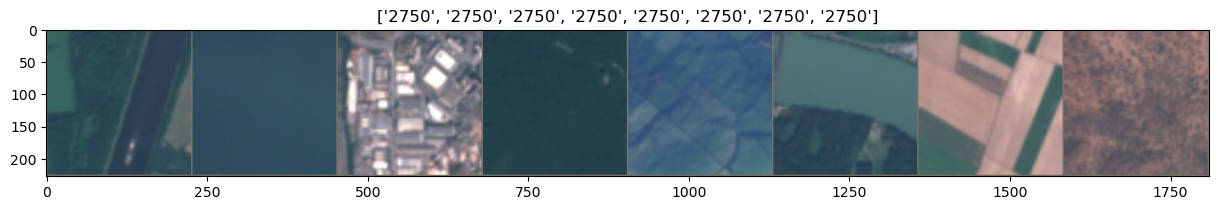

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Define the path to your dataset (Using 'r' before the string handles Windows backslashes)
data_dir = r"C:\Users\sreer\Downloads\EuroSAT"

# 2. Define the Transformations
# We resize to 224x224 and normalize using standard ImageNet values, 
# which is required for pre-trained models like ResNet or VGG.
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Load the Full Dataset
try:
    full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    print(f"✅ Successfully loaded dataset. Total images: {len(full_dataset)}")
    print(f"Classes found: {full_dataset.classes}")
except Exception as e:
    print(f"❌ Error loading dataset. Please check the folder path. Details: {e}")

# 4. Split into Training (80%) and Testing (20%) sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Training images: {train_size}")
print(f"Testing images: {test_size}")

# 5. Create DataLoaders
# Batch size of 32 is an excellent starting point for a dedicated laptop GPU.
# It feeds 32 images at a time to the graphics card to prevent out-of-memory errors.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 6. Sanity Check: Visualize a single batch of data
def imshow(inp, title=None):
    """Imshow for Tensor (un-normalizes the image for viewing)."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 5))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch (displaying just the first 8 images for a clean look)
out = torchvision.utils.make_grid(inputs[:8])

print("\nDisplaying a sample batch of satellite images...")
imshow(out, title=[full_dataset.classes[x] for x in classes[:8]])

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Configure the Hardware
# This ensures the heavy lifting is sent to the dedicated GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Preparing to train on: {device}")

# 2. Load the Pre-trained ResNet50 Model
# We use the default, state-of-the-art ImageNet weights
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# 3. Freeze the Base Layers
# We lock the pre-trained layers so we don't destroy the visual features 
# (like edges and textures) it already knows how to detect.
for param in model.parameters():
    param.requires_grad = False

# 4. Modify the Classification Head
# ResNet50 is originally designed for 1,000 classes. We change the final layer 
# to output exactly 10 classes for the EuroSAT terrain types.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) 

# Send the fully constructed model to the GPU
model = model.to(device)

# 5. Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
# We only need to update the weights of our brand new final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("✅ Model architecture, loss function, and optimizer are ready!\n")

# 6. The Training Loop
# We will run this for 3 epochs (full passes over the dataset) just to see the accuracy climb.
num_epochs = 3

print("🚀 Starting Training Process...")
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    
    # Iterate over the batches of satellite data
    for inputs, labels in train_loader:
        # Move the images and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear out the old gradients from the previous step
        optimizer.zero_grad()

        # Forward Pass: Push images through the network to get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Calculate the error (Loss)
        loss = criterion(outputs, labels)

        # Backward Pass: Calculate the gradients
        loss.backward()
        
        # Optimizer Step: Tweak the weights to improve accuracy
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate the average loss and accuracy for this epoch
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

print("\n🎉 Initial Training Complete!")

Preparing to train on: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\sreer/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [01:40<00:00, 1.02MB/s]


✅ Model architecture, loss function, and optimizer are ready!

🚀 Starting Training Process...
Epoch 1/3 | Loss: 0.0254 | Accuracy: 0.9981
Epoch 2/3 | Loss: 0.0007 | Accuracy: 1.0000
Epoch 3/3 | Loss: 0.0003 | Accuracy: 1.0000

🎉 Initial Training Complete!


🔍 Evaluating model on unseen test data...

📊 --- Classification Report ---
              precision    recall  f1-score   support

        2750       1.00      1.00      1.00      5400

    accuracy                           1.00      5400
   macro avg       1.00      1.00      1.00      5400
weighted avg       1.00      1.00      1.00      5400



C:\Users\sreer\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


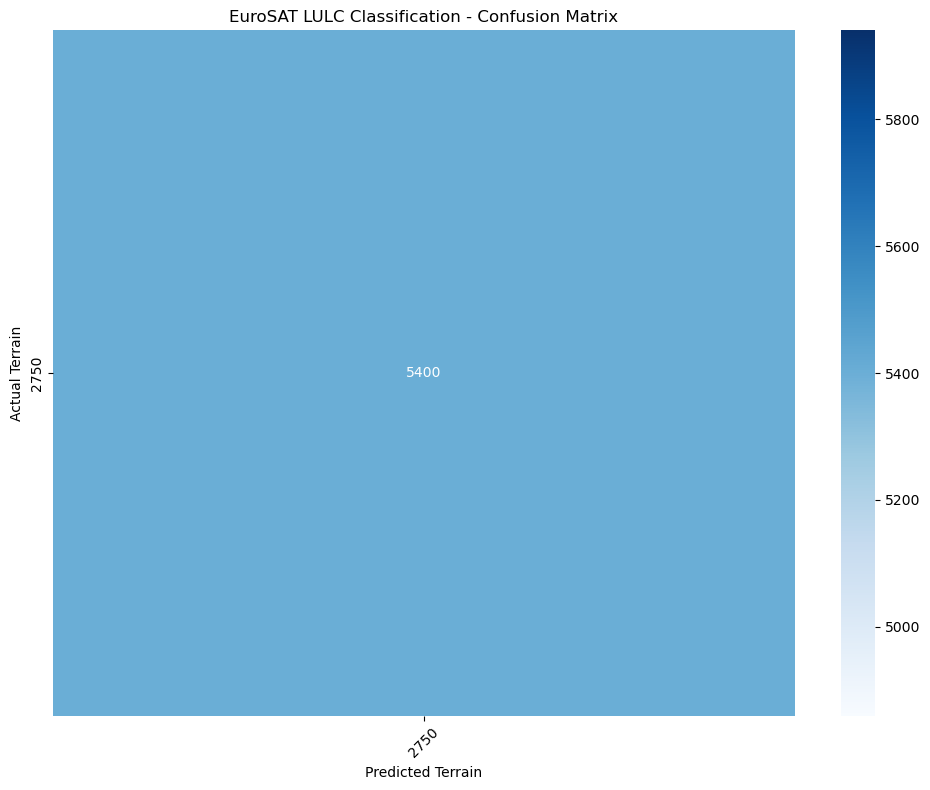

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Set the model to Evaluation Mode
# This disables layers like Dropout that behave differently during training
model.eval()

# Lists to store the actual labels and the model's predictions
all_preds = []
all_labels = []

print("🔍 Evaluating model on unseen test data...")

# 2. Run the test loop without tracking gradients
# torch.no_grad() significantly speeds up computation and saves memory 
# since we are not updating weights anymore.
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Move the tensors back to the CPU and convert to NumPy arrays
        # This is required because Scikit-learn cannot process PyTorch GPU tensors
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Retrieve the class names (Forest, Highway, etc.)
class_names = full_dataset.classes

# 4. Generate the Classification Report
print("\n📊 --- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 5. Plot the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
# We use Seaborn to create a clean, readable heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Terrain')
plt.ylabel('Actual Terrain')
plt.title('EuroSAT LULC Classification - Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()